In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import string
import re
import spacy
import gensim
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../data/cleaned.csv",usecols=['review','year'])
df.head()

,review,year
0,As usual the flight is delayed. BA try to blam...,2023
1,I had the most fantastic BA Flight today. The ...,2023
2,Couldn’t book in online. Arrived at check in t...,2023
3,London Heathrow to Mumbai in a Boeing 787-8 in...,2023
4,"Keflavík, Iceland to London Heathrow on an A32...",2023


In [3]:
df_copy = df.copy()
df_copy.describe()

,year
count,3604.000000
mean,2017.078246
std,2.557902
min,2011.000000
25%,2015.000000
50%,2017.000000
75%,2019.000000
max,2023.000000


In [4]:
# https://stackoverflow.com/questions/56909294/how-to-set-time-slices-dynamic-topic-model
# You must order from oldest date to newest date
texts = df_copy.sort_values(by='year',ascending=True) 

In [5]:
texts = texts.reset_index()

In [6]:
texts.head()

,index,review,year
0,3603,SIN-LHR BA12 B747-436 First Class. Old aircraf...,2011
1,3602,London City-New York JFK via Shannon on A318 b...,2011
2,3601,My son who had worked for British Airways urge...,2011
3,3589,Heathrow Marrakech. Had previously travelled o...,2012
4,3590,Flew return in CW from LHR to BKK in August 20...,2012


In [7]:
texts.drop('index',axis=1,inplace=True)

In [8]:
docs = texts.review.tolist()
year = texts.year.tolist()

In [9]:
def inspector(index_value=0):
    print(docs[index_value],"\n")
inspector(10)

Just got back from Bridgetown Barbados flying with British Airways and frankly couldn't wait to get off. I was so disappointed. I have travelled regularly with BA but the flights going over and coming back left a lot to be desired. The plane was in need of repair. I had water dripping from the ceiling where I was sitting and when I told the stewardess was told that was usual due to condensation and proceeded to stuff a tissue to stop the dripping. The toilets were so old that bits of the cladding were coming away. The food was awful and inedible. The staff were unapproachable and looked fed up. BA get your act together or you'll be losing flyers by the hundreds. 



### **BerTopic**

In [10]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pickle

In [11]:
# Loading the transformer model
import os

# Determine the paths to the directories on the desktop
desktop_path = os.path.expanduser("~/Desktop")
machtensor = os.path.join(desktop_path,"machtensor")

# Specify the path to the file in "subfolders" 
nlp = os.path.join(machtensor,"nlp")
topic_modelling = os.path.join(nlp,"topic_modelling")
amazon_topic_modellig = os.path.join(topic_modelling,'amazon_topic_modellig')
model = os.path.join(amazon_topic_modellig,'model')
sentence_transformer = os.path.join(model,'sentence_transformer')
file_name = "sentence_model.pkl" # file name
file_path = os.path.join(sentence_transformer,file_name)

# Read the Pickle file
with open(file_path,'rb') as file:
    sentence_model = pickle.load(file)

print(sentence_model) # The sentence transformer

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)


In [36]:
embeddings = sentence_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/113 [00:00<?, ?it/s]

In [97]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
# cluster_model  = KMeans(n_clusters=4)
hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', 
        cluster_selection_method='eom', prediction_data=True)
vectoriser_model = CountVectorizer(ngram_range=(1,3),stop_words="english")

In [98]:
topic_model = BERTopic(
    verbose=True,
    min_topic_size = 50,
    n_gram_range=(1,3),
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectoriser_model,
    calculate_probabilities=True,
    embedding_model=sentence_model,
    )
topics, probs = topic_model.fit_transform(docs,embeddings)
# AssertionError: Torch not compiled with CUDA enabled
# Reinstall torch with cuda
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

2023-11-03 15:05:19,775 - BERTopic - Reduced dimensionality
2023-11-03 15:05:20,627 - BERTopic - Clustered reduced embeddings


**Topic Information**

In [99]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1337,-1_flight_ba_service_food
1,0,804,0_flight_ba_british_airways
2,1,454,1_lhr_good_flight_seat
3,2,324,2_gatwick_flight_ba_crew
4,3,162,3_london_flight_good_heathrow
5,4,150,4_flight_food_meal_served
6,5,81,5_class_business_business class_british
7,6,50,6_bangkok_flight_airways_bangkok london
8,7,44,7_singapore_sydney_qantas_service
9,8,35,8_madrid_iberia_flight_service


In [100]:
topic_model.visualize_heatmap()

**Selecting a topic**

In [101]:
def topic_selector(topic):
    return topic_model.get_topic(topic)
selected_topic = topic_selector(0)
selected_topic

[('flight', 0.02147388490424869),
 ('ba', 0.015571758835932332),
 ('british', 0.010440381114684672),
 ('airways', 0.010421411462865028),
 ('british airways', 0.010283454685614856),
 ('told', 0.009351998588056508),
 ('london', 0.009284084173252955),
 ('check', 0.008918310556548377),
 ('customer', 0.0087824431850413),
 ('hours', 0.008701839982588054)]

In [102]:
# Reducing outliers using the c-tf-idf strategy
# Calculate the c-TF-IDF representation for each outlier document and
# find the best matching c-TF-IDF topic representation using cosine similarity.
new_topics = topic_model.reduce_outliers(docs,topics=topics, strategy='c-tf-idf')

# Updating Topic Representations
topic_model.update_topics(docs,topics=new_topics)

In [107]:
# Reducing the topics
# Was experiencing some errors with this for some reason
# topic_model.reduce_topics(docs,nr_topics=4) 
# IndexError: index 15 is out of bounds for axis 0 with size 15

In [108]:
topic_model.get_topic_info() # No more outliers

,Topic,Count,Name
0,0,1095,0_to_the_and_was
1,1,957,1_the_and_was_to
2,2,487,2_the_and_to_was
3,3,282,3_the_and_was_to
4,4,251,4_the_was_and_to
5,5,192,5_the_class_business_and
6,6,54,6_the_to_and_was
7,7,49,7_the_and_singapore_to
8,8,36,8_and_the_to_madrid
9,9,31,9_to_the_and_london


In [74]:
selected_topic = topic_selector(0)
selected_topic

[('the', 0.046825428920654),
 ('and', 0.036174237268905104),
 ('was', 0.02902089841129515),
 ('to', 0.02678894447610211),
 ('on', 0.02139706933964549),
 ('in', 0.02075159806285179),
 ('of', 0.018564876400236994),
 ('flight', 0.015026758146841838),
 ('with', 0.014915732803378665),
 ('is', 0.014631865078071165)]

In [111]:
topic_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
topic_model.visualize_heatmap(topics=topic_list)

**Observations**
- Topics 0,1,3,4,5,10-11,14, will be merged because of a high level of correlation between them.

In [112]:
topics_merges = [0,1,3,4,5,10,11,14]
topic_model.merge_topics(docs=docs,topics_to_merge=topics_merges)

In [113]:
topic_model.get_topic_info() # After merging topics

,Topic,Count,Name
0,0,2850,0_the_to_and_was
1,1,487,1_the_and_to_was
2,2,54,2_the_to_and_was
3,3,50,3_economy_the_premium_premium economy
4,4,49,4_the_and_to_singapore
5,5,36,5_and_the_to_madrid
6,6,31,6_to_the_and_london
7,7,25,7_the_and_to_was
8,8,22,8_the_to_and_for


**Visualisation**

In [126]:
topic_model.visualize_topics()

In [127]:
topics_merges2 = [[0,1],[2,3,4],[5,6,8]]
topic_model.merge_topics(docs=docs,topics_to_merge=topics_merges2)

In [128]:
topic_model.get_topic_info() # After merging topics

,Topic,Count,Name
0,0,3337,0_the_to_and_was
1,1,153,1_the_to_and_was
2,2,89,2_the_to_and_on
3,3,25,3_the_and_to_was


In [129]:
topic_model.visualize_topics()

In [130]:
topic_model.visualize_documents(docs=docs,hide_annotations=True)

In [131]:
topic_model.visualize_barchart(n_words=10)

**Getting documents that represent the topic cluster**

In [125]:
def representative_docs_retrieval(topic):
    representative_docs = topic_model.get_representative_docs(topic)
    print(f"Topic {topic}\n")
    for document in representative_docs:
        print(f"Documents:\n{document}\n")

In [132]:
representative_docs_retrieval(0)

Topic 0

Documents:
London City to Dusseldorf return, flights operated on behalf of BA by Eastern Airways. The cabin was clean on both aircraft and the check in and wait at the both the airports were reasonable however then the good part of the trip ceases. Cabin Crew must of been members of the Basil Fawlty school of Catering. The outward flight there were 3 passengers in the business class cabin and the onboard menu was handed out to the three of us. The young stewardess took our orders, then we heard a crash as the young stewardess promptly dropped one of the meal and told us that the aircraft only had two meals and asked for a volunteer to give up their meal. The meal was of a reasonable quality and well presented. On arrival at Dusseldorf the aircraft was parked at a remote stand and we were taken by bus to the wrong terminal. The arrivals boards in the airport say terminal B and we were dropped off at Terminal C. Our delivered to terminal C and we had to walk to Terminal B if you

In [133]:
representative_docs_retrieval(1)

Topic 1

Documents:
Sydney to London via Singapore. It has been a very long time since I was on a long haul with BA of more than 9 hours. Last year had a relative sprint from London to JFK and before that in 2002. The years have not been kind to BA. Probably a mixture of the decline of BA and the emergence of other airlines. Nearly all my long haul is with Qantas on its A380, occasionally Emirates on its version and then once in a while with Cathay Pacific and American Airlines. The problem is not the hard product. A B777 or the A380 in whatever colour and decor is ordered is the same air frame. The B777 from Sydney to Singapore was fine. Nosier than the A380 but that is well known. Very comfortable seats and at 8 hours a relative sprint for those who call Sydney home. It is the soft product that is lacking. Check in was fine and despite being in Economy had an express pass through security (being a Gold FF with Qantas). Boarding was orderly and an on time departure and arrival into Si

In [134]:
representative_docs_retrieval(2)

Topic 2

Documents:
Flew from EDI-LHR-PHL-LHR-EDI in World Traveller. Outbound shuttle to Heathrow was a Boeing 767-300 in all economy layout, managed to bag seats 1F/1G using online checkin. Cheery, friendly crew - biggest problem is the excessive hand baggage allowance permitted on BA. Selfish people take huge cases on board, filling up the lockers so everyone with more modestly sized items can't get a look in. Cabin crew quite stressed trying to move cases around lockers to get everyone sat down. LHR-PHL upgraded to the rearmost group of two seats on Row 35 on  Boeing 777-200. BA has now cheekily increased the cost of these to £48 each - used to be only £33 like the rest of the cabin. Wisecracking captain over the tannoy made the flight a little more entertaining - again great crew, I could eat the meal for once. Only thing that went wrong was the IFE on my seat crashed in the last 90 minutes of the flight - I could only view the flight tracker. On a side note, I wish BA would upgra

In [135]:
representative_docs_retrieval(3)

Topic 3

Documents:
Mumbai to Edinburgh via London. I'm quite surprised to read the varied reviews as I have always had a great experience with BA in terms of in-flight service and airport handling. After sales service can be a different experience! This flight I arrived a little late at the airport due to transport issues, hot and sweaty and the check-in girl was such a blessing. She calmed me down, reassured me and helped me get through security swiftly. I was able to secure a very cheap last-minute upgrade to Premium Economy and I am so glad I did. The service was wonderful, we were looked after very well, lots of water offered throughout the flight. I thought the seat was tremendously spacious and comfortable, even for the regular upgrade price, 2 rather than 3 seats to the side and 3 rather than 4 in the centre, gives you a lot more space. The food was ok, I've had worse, I've had better. But I was comfortable, a good temperature and had a great choice of films. My connecting plan

**Observations**
- Topic 0 --> Flight experience
- Topic 1 --> Service complaints
- Topic 2 --> good/bad reviews
- Topic 3 --> Good reviews

**Converting the model found topic into dataframe**

In [136]:
data = {"topic":topic_model.topics_,"document":docs}
df =pd.DataFrame(data)
df.to_csv("model_versions/topics/data/4_topics.csv")

In [137]:
# Saving the visuals
fig = topic_model.visualize_topics()
fig.write_html("model_versions/topics/visuals/4_topics.html")

In [139]:
# Saving the visuals
fig = topic_model.visualize_documents(docs=docs,hide_annotations=True)
fig.write_html("model_versions/topics/visuals/4_topics_visualize_documents.html")

**Renaming the topic names**

In [140]:
topics_new_labels = {
    
    0:"flight experience",
    1:"service complaints",
    2:"good and bad reviews",
    3:"good reviews",   
}

topic_model.set_topic_labels(topics_new_labels)

In [146]:
data = {"topic":topic_model.topics_,"document":docs}
df =pd.DataFrame(data)
df["topic_names"] = df.topic.map(topics_new_labels)
reorder = ['topic','topic_names','document']
df = df[reorder]
df.to_csv("model_versions/topics/data/4_topics.csv",index=False)

**Understand why a Single Document is assigned to a particular Topic**

In [147]:
# Calculate the topic distributions on a token level
# Note that we need to have `calculate_token=True`
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs,calculate_tokens=True)

100%|██████████| 4/4 [00:19<00:00,  4.81s/it]


In [157]:
def visualize_approximate_distributions(doc_id=0):
    return topic_model.visualize_approximate_distribution(document=docs[doc_id],topic_token_distribution=topic_token_distr[doc_id])

In [162]:
doc_vis = visualize_approximate_distributions(100)
doc_vis

,Orlando,Florida,MCO,London,Gatwick,LGW,Wed,Aug,27,return,...,addition,the,inflight,entertainment,didn,work,on,our,return,trip


In [168]:
doc_vis = visualize_approximate_distributions(200)
doc_vis

,Went,to,BKK,via,Heathrow,on,26th,October,Was,all,excited,to,be,flying,back,to,Thailand,know,direct,flights,are,better,but,longer,but,thought,flying,with,the,UK,flag,carrier,was,going,to,get,good,flight,Well,to,be,honest,was,disappointed,was,at,least,expecting,to,be,able,to,charge,phone,onboard,only,to,be,told,only,in,business,class,Most,other,airlines,have,this,facility,in,economy,No,menus,for,food,and,options,and,same,with,breakfast,Drinks,were,limited,to,soft,and,only,wine,and,beer,Inflight,entertainment,was,poor,at,best,and,was,bored,witless,with,films,have,seen,before,or,had,no,interest,in,Even,the,documentaries,were,all,BBC,which,were,ok,Music,was,equally,lacklustre,and,limited,Only,saving,grace,was,the,seat,was,in,and,that,was,the,only,positive,aspect,despite,the,fact,there,was,baby,crying,most,of,the,time,Sorry,BA,was,expecting,good,experience,but,felt,let,down,and,disappointed
1_the_to_and_was,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.105,0.105,0.105,0.105,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.100,0.262,0.415,0.534,0.546,0.507,0.515,0.523,0.410,0.287,0.126,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.120,0.120,0.120,0.120,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2_the_to_and_on,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.117,0.117,0.117,0.117,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.107,0.217,0.217,0.217,0.217,0.245,0.355,0.355,0.247,0.109,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.116,0.116,0.116,0.116,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3_the_and_to_was,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.104,0.104,0.104,0.104,0.000,0.105,0.105,0.105,0.105,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [172]:
def visualize_distributions(doc_id=0):
    return topic_model.visualize_distribution(topic_model.probabilities_[doc_id],custom_labels=False)

In [173]:
doc_vis_distr = visualize_distributions(100)
doc_vis_distr

In [174]:
doc_vis_distr = visualize_distributions(200)
doc_vis_distr

**Wordcloud visualisation**

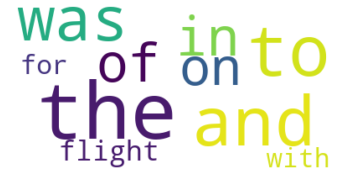

In [177]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

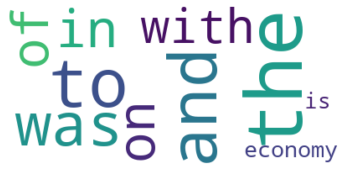

In [178]:
create_wordcloud(topic_model, topic=1)

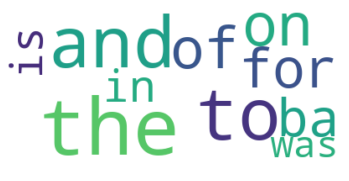

In [179]:
create_wordcloud(topic_model, topic=2)

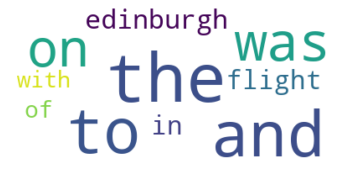

In [180]:
create_wordcloud(topic_model, topic=3)

In [181]:
hierarchical_topics = topic_model.hierarchical_topics(docs)

100%|██████████| 2/2 [00:00<00:00,  5.28it/s]


In [183]:
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─■──the_to_and_on_of ── Topic: 2
└─the_to_and_was_in
     ├─■──the_to_and_was_in ── Topic: 0
     └─■──the_to_and_was_in ── Topic: 1



In [184]:
hierarchical_topics

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
1,4,the_to_and_was_in,"[0, 1, 2]",2,the_to_and_on_of,3,the_to_and_was_in,0.431388
0,3,the_to_and_was_in,"[0, 1]",0,the_to_and_was_in,1,the_to_and_was_in,0.209979


In [185]:
topic_model.visualize_hierarchy()

**Observations**
- Generally you could have two topics
- Topics 0 and 1 could be merged into one whole topic from the beginning.

### **DTM (Dynamic Topic Modelling)**

In [186]:
topics_over_time = topic_model.topics_over_time(docs,year)

12it [06:18, 31.56s/it]


In [187]:
topic_model.visualize_topics_over_time(topics_over_time,title="<b>Topics Formation of British Airways Reviews Over Time <b>")

**Observations**
- Topic 0 formation begins from 2011, while the rest begins from 2014.
- Topic 3's formation stops at 2022.
- Topic 0 has the highest frequency of appearance amongst all topics over time.

In [188]:
fig = topic_model.visualize_topics_over_time(topics_over_time,title="<b>Topics Formation of British Airways Reviews Over Time <b>")
fig.write_html("model_versions/topics/visuals/4_topics_over_time.html")

In [194]:
# topic_mapping = {
#     0:"flight experience",
#     1:"service complaints",
#     2:"good and bad reviews",
#     3:"good reviews",   
# }

In [202]:
# # Saving the model
# topic_model.save("model_versions/models/4_model",save_embedding_model=True)

In [203]:
# # Loading the saved model
# model_loaded = BERTopic.load("model_versions/models/4_model")

In [213]:
# # Needs to be looked into
# def use_compute(texts):
#     embeddings = sentence_model.encode(texts, show_progress_bar=True)
#     topics_new, probs_new = model_loaded.transform(texts,embeddings)
#     # new_topics = model_loaded.reduce_outliers(texts,topics=topics_new, strategy='c-tf-idf')

#     # # Updating Topic Representations
#     # model_loaded.update_topics(texts,topics=new_topics)
#     # topic_mapped = topic_mapping[topics_new[0]]
#     for text in texts:
#         print(text,"\n")
#         print("-----------------------------------------------------------------------------------")
#         print(f"Suggested Topic of the texts: {topics_new}")
    
    
#     # print(text)
#     # print("-----------------------------------------------------------------------------------")
#     # print("Topic id: ",topics_new)
#     # topic_new = topic_model.topic_names[topics_new[0]]
#     # print("Topic name: ",topic_new)
#     # print("-----------------------------------------------------------------------------------")
#     # print("Suggested Topic: \n")
#     # f_t = topic_model.find_topics(topic_new)
#     # for i in f_t[0]:
#     #     print(topic_model.topic_names[i],"\n")

In [215]:
# text = ["""As a British Airways passenger, I had the opportunity to experience a recent flight with the airline. Overall, my flight experience with British Airways had both positive and negative aspects.

# Let's start with the positive aspects of the flight. The cabin crew was friendly, attentive, and provided excellent customer service throughout the journey. They were always available to assist with any requests and made the passengers feel comfortable and well taken care of. The in-flight entertainment system was also impressive, offering a wide range of movies, TV shows, and music to keep passengers entertained during the flight. The seats were reasonably comfortable, and the meals served were of good quality.

# However, there were some negative aspects to the flight experience as well. The flight departed a bit late, causing some inconvenience for passengers with tight connections. The legroom in economy class was somewhat limited, and the seats could be more comfortable for long-haul flights. Additionally, the WiFi service on the plane was unreliable, making it difficult to stay connected during the journey.

# In conclusion, my flight with British Airways had its highs and lows. The excellent cabin crew and in-flight entertainment were definite highlights, but the minor delays, seat comfort, and WiFi issues left room for improvement. It was a mixed experience."""]

# use_compute(text)

In [214]:
# text = ["""I hate it"""]

# use_compute(text)